# Parkinson Classification

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# read the file
environment_path = "C:\\MARTIN EDUARDO\\University Of Leeds\\Dissertation\\Classification_bradykinesia_KalmanFilter"
file_path = environment_path + "\\Data\\data\\mediaPipe_videos.csv"

C:\Users\Martin Espinoza\anaconda3\envs\gpu3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parkinson Class:

In [2]:
class ParkinsonRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(ParkinsonRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

### Functions:

In [3]:
# read the file
def read_file(file_path):
    df = pd.read_csv(file_path)
    return df

# read videos
def read_videos(file_path):
    student_names = [name for name in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, name))]
    all_videos = []
    for student_name in student_names:
        video_path = os.path.join(file_path, student_name)
        video_names = [os.path.splitext(name)[0] for name in os.listdir(video_path) if os.path.isfile(os.path.join(video_path, name))]
        all_videos.extend(video_names)
    return all_videos

# calculate the number of max frames (T)
def calculate_maxT(df, all_videos):
    maxT = 0
    for video in all_videos:
        maxT = max(maxT, df[df['image_name'].str.startswith(video)].shape[0])
    return maxT

# fill the tensor and labels
def fill_tensors_and_labels(df, mytensor, labels, all_videos, maxT):
    num_videos = len(all_videos)
    for i, video in enumerate(all_videos):
        video_data = df[df['image_name'].str.startswith(video)]
        T = video_data.shape[0]
        if T <= maxT:
            mytensor[i, 0, :T] = video_data['finger_x']
            mytensor[i, 1, :T] = video_data['finger_y']
            mytensor[i, 2, :T] = video_data['thumb_x']
            mytensor[i, 3, :T] = video_data['thumb_y']
            mytensor[i, 4, :T] = video_data['distance']
        else:
            mytensor[i, 0, :maxT] = video_data['finger_x'][:maxT]
            mytensor[i, 1, :maxT] = video_data['finger_y'][:maxT]
            mytensor[i, 2, :maxT] = video_data['thumb_x'][:maxT]
            mytensor[i, 3, :maxT] = video_data['thumb_y'][:maxT]
            mytensor[i, 4, :maxT] = video_data['distance'][:maxT]
        if video.startswith('P'):
            labels[i] = 1
    return mytensor, labels

# dataloaders for training
def create_train_and_validation_loaders(tensor_x, tensor_y, batch_size):
    # split into training and validation
    dataset = TensorDataset(tensor_x, tensor_y)
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    validation_split = 0.2
    split = int(np.floor(validation_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    return train_loader, validation_loader

# train the Parkinson model
def training_model(model, train_loader, validation_loader, num_epochs, learning_rate):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # to store the losses
    train_losses = []
    val_losses = []

    # training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, labels in train_loader:
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, labels in validation_loader:
                outputs = model(sequences)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        val_loss /= len(validation_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    return model, train_losses, val_losses

# make the predictions
def make_predictions(model, test_loader):
    model.eval()
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions = torch.sigmoid(outputs).cpu().numpy()
            test_predictions.extend(predictions)
            test_targets.extend(labels.numpy())

    # metrics
    test_predictions = np.array(test_predictions).flatten()
    test_targets = np.array(test_targets)

    accuracy = accuracy_score(test_targets, np.round(test_predictions))
    recall = recall_score(test_targets, np.round(test_predictions))
    f1 = f1_score(test_targets, np.round(test_predictions))
    roc_auc = roc_auc_score(test_targets, test_predictions)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')
    print(f'Test AUROC: {roc_auc:.4f}')

# ploting the losses
def plot_losses(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

### Train the Model

In [4]:
# parameters
batch_size = 32
input_size = 5
hidden_size = 256  
num_layers = 3 
output_size = 1
learning_rate = 0.0001
dropout = 0.5
num_epochs = 200

In [5]:
# read the files
df = read_file(file_path) # train file

# read videos
all_videos = read_videos(environment_path + "\\Data\\videos_data\\videos_lowfps\\")

# calculate the number of max frames (T)
maxT = calculate_maxT(df, all_videos)

# create the tensor and labels
num_videos = len(all_videos)
mytensor = np.zeros([num_videos, 5, maxT])
labels = np.zeros(num_videos)

# fill the tensor and labels
mytensor, labels = fill_tensors_and_labels(df, mytensor, labels, all_videos, maxT)

# tensors for x and y
tensor_x = torch.tensor(mytensor, dtype=torch.float32).permute(0, 2, 1)
tensor_y = torch.tensor(labels, dtype=torch.float32)

# train and validation loaders
train_loader, validation_loader = create_train_and_validation_loaders(tensor_x, tensor_y, batch_size)

# train the model
model = ParkinsonRNN(input_size, hidden_size, num_layers, output_size, dropout)
model, train_losses, val_losses = training_model(model, train_loader, validation_loader, num_epochs, learning_rate)

Epoch [1/200], Loss: 0.6939, Validation Loss: 0.6970
Epoch [2/200], Loss: 0.6940, Validation Loss: 0.6968
Epoch [3/200], Loss: 0.6926, Validation Loss: 0.6965
Epoch [4/200], Loss: 0.6932, Validation Loss: 0.6963
Epoch [5/200], Loss: 0.6925, Validation Loss: 0.6960
Epoch [6/200], Loss: 0.6912, Validation Loss: 0.6957
Epoch [7/200], Loss: 0.6917, Validation Loss: 0.6954
Epoch [8/200], Loss: 0.6925, Validation Loss: 0.6952
Epoch [9/200], Loss: 0.6928, Validation Loss: 0.6951
Epoch [10/200], Loss: 0.6940, Validation Loss: 0.6949
Epoch [11/200], Loss: 0.6937, Validation Loss: 0.6946
Epoch [12/200], Loss: 0.6929, Validation Loss: 0.6943
Epoch [13/200], Loss: 0.6923, Validation Loss: 0.6940
Epoch [14/200], Loss: 0.6937, Validation Loss: 0.6939
Epoch [15/200], Loss: 0.6908, Validation Loss: 0.6937
Epoch [16/200], Loss: 0.6905, Validation Loss: 0.6935
Epoch [17/200], Loss: 0.6913, Validation Loss: 0.6933
Epoch [18/200], Loss: 0.6930, Validation Loss: 0.6932
Epoch [19/200], Loss: 0.6952, Validat

Epoch [152/200], Loss: 0.5021, Validation Loss: 0.5184
Epoch [153/200], Loss: 0.5424, Validation Loss: 0.5165
Epoch [154/200], Loss: 0.5012, Validation Loss: 0.5153
Epoch [155/200], Loss: 0.5280, Validation Loss: 0.5158
Epoch [156/200], Loss: 0.5292, Validation Loss: 0.5145
Epoch [157/200], Loss: 0.5339, Validation Loss: 0.5156
Epoch [158/200], Loss: 0.4801, Validation Loss: 0.5128
Epoch [159/200], Loss: 0.5203, Validation Loss: 0.5108
Epoch [160/200], Loss: 0.4927, Validation Loss: 0.5095
Epoch [161/200], Loss: 0.5211, Validation Loss: 0.5093
Epoch [162/200], Loss: 0.5281, Validation Loss: 0.5067
Epoch [163/200], Loss: 0.4972, Validation Loss: 0.5068
Epoch [164/200], Loss: 0.5024, Validation Loss: 0.5064
Epoch [165/200], Loss: 0.4766, Validation Loss: 0.5032
Epoch [166/200], Loss: 0.4965, Validation Loss: 0.5032
Epoch [167/200], Loss: 0.5389, Validation Loss: 0.5046
Epoch [168/200], Loss: 0.5185, Validation Loss: 0.5150
Epoch [169/200], Loss: 0.5350, Validation Loss: 0.5053
Epoch [170

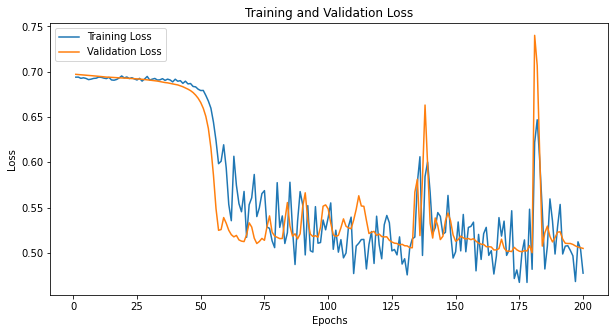

In [6]:
plot_losses(train_losses, val_losses, num_epochs)

### Test the model

In [7]:
# read the test file
test_df = read_file(environment_path + "\\Data\\data\\test_mediaPipe_videos.csv")

# read the test videos
test_all_videos = read_videos(environment_path + "\\Data\\videos_data\\test_videos_lowfps\\")

# calculate the number of max frames (T) for test data
test_maxT = calculate_maxT(test_df, test_all_videos)

# create the tensor and labels for test data
test_num_videos = len(test_all_videos)
test_mytensor = np.zeros([test_num_videos, 5, test_maxT])
test_labels = np.zeros(test_num_videos)

# fill the tensor and labels for test data
test_mytensor, test_labels = fill_tensors_and_labels(test_df, test_mytensor, test_labels, test_all_videos, test_maxT)

# tensors for x and y
test_tensor_x = torch.tensor(test_mytensor, dtype=torch.float32).permute(0, 2, 1)
test_tensor_y = torch.tensor(test_labels, dtype=torch.float32)

# dataloader for test data
test_dataset = TensorDataset(test_tensor_x, test_tensor_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# make predictions
make_predictions(model, test_loader)

Test Accuracy: 0.6667
Test Recall: 1.0000
Test F1-score: 0.7692
Test AUROC: 0.7500
